# Week 7 - Deep Learning

### April 7, 2017

#### Objectives
  1. Combine operations & clinical features to determine if both domains of features improve the regression model.
  2. Apply Deep Learning

In [44]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sys, os

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=False):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

# Dataset

## Interval: 30 Days
Patients' ICU admissions within the last 30 days from the current ICU stay.

## Exclusion Criteria
1. Minors

## Features (`X`)

### Operations
* **`subjectid`**: subject ID of patients
* **`icustayid`**: ID of a unique ICU stay
* **`readm_days`**: number of days since discharge of previous ICU stay
* **`prev_iculos`**: total length of stay (LOS) of the previous unique ICU stay
* **`age`**: age of patient at the times of ICU admission
* **`ethnicity`**: categorical feature indicating ethnicity group
* **`marital_status`**: categorical feature indicating marital status.
* **`insurance`**: categorical feature indicating insurance type.
* **`NonEnglish`**: binary feature indicating non-english speaker.
* **`N`<sub>icutrav</sub>**: the number of total intra-ICU ward transfers (non-unique ICU stays)
* **`prev_cu`**: categorical feature indicating previous care unit
* **`curr_cu`**: categorical feature indicating current care unit
* **`prev_ICU`**: binary feature indicating if previous care unit was an ICU type
* **`disch_cu`**: categorical feature indicating discharge care unit from ICU stay
* **`disch_ICU`**: binary feature indicating if discharge care unit was an ICU type
* **`icu_in_day`**: time of ICU admission (day/night)
* **`icu_out_day`**: time of ICU discharge (day/night)
* **`readm_risk`**: risk score of intra-patient unique ICU readmissions
* Transfer Pairs
    * **`nonicu-MICU`**	
    * **`nonicu-SICU`**	
    * **`nonicu-TSICU`**	
    * **`nonicu-CSRU`**	
    * **`MICU-MICU`**	
    * **`TSICU-TSICU`**	
    * **`nonicu-CCU`**	
    * **`CCU-CCU`**
    * **`CSRU-CSRU`**	
    * **`SICU-SICU`**	
    
### Clinical
  * **Surgical Patients**: binary feature indicating the presence of surgery during an ICU stay 
  * **Abnormal Hemoglobin**: binary feature indicating the presence of abnormal hemoglobin results
  * **HADM Procedures**: series of binary features indicating presence of procedures during hospital admission.
 
## Dependent Variables/Response (`Y`) 
  * **`icu_los`**: ICU length of stay

### Unique ICU stays

Features:
  * **`subjectid`**: subject ID of patients
  * **`icustaysid`**: ID of a unique ICU stay
  * **`readm_days`**: number of days since discharge of previous ICU stay to admission of current ICU stay (ICU readmission)

In [3]:
def prev_icutime(data):
    if data['readm_days'] == np.nan:
        pass
    else:
        prev_icutime = data['icu_intime'] - data['readm_days'] # time of previous ICU discharge/transfer
        return prev_icutime

In [4]:
# query
q_icustay="""SELECT subject_id, hadm_id, icustay_id, min_in, max_out,
min_in - lag(max_out)
OVER (PARTITION BY subject_id ORDER BY min_in) AS diff
FROM
(SELECT subject_id, hadm_id, icustay_id, 
MIN(intime) as min_in, MAX(outtime) AS max_out
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY subject_id, hadm_id, icustay_id) as sub_q
ORDER BY subject_id
"""

# Query output
icustay = exec_query(q_icustay)
df_icustay = pd.DataFrame(icustay, columns=['subjectid', 'hadmid', 'icustayid', 
                                            'icu_intime', # first unique ICU admission time 
                                            'icu_outtime', #  unique ICU discharge time
                                            'readm_days']) # number of days since last ICU discharge/transfer

df_icustay['icu_prev_outtime'] = df_icustay.apply(prev_icutime, axis=1)
# df_icustay.readm_days.fillna(0, inplace=True)
df_icustay.readm_days.dropna(inplace=True)
df_icustay['readm_days'] = np.round(df_icustay['readm_days'].astype(int) * (1/8.64e13), 3)
print df_icustay.shape
df_icustay.head()

(61532, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
0,2,163353,243653,2138-07-17 21:20:07,2138-07-17 23:32:21,NaN,NaT
1,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,NaT
2,4,185777,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,NaN,NaT
3,5,178980,214757,2103-02-02 06:04:24,2103-02-02 08:06:00,NaN,NaT
4,6,107064,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,NaN,NaT


Filter for patients with ICU readmissions.

In [5]:
# query
q_readm_pat ="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
readm_pat = exec_query(q_readm_pat, False)
df_readm_pat = pd.DataFrame(readm_pat, columns=['subjectid', 'n_icustays'])

df_readm = df_icustay[df_icustay['subjectid'].isin(df_readm_pat.subjectid)]
print df_readm.shape
df_readm.head()

(23811, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
5,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaT
6,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,2121-05-23 22:01:00
14,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaT
15,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,2134-12-29 18:04:03
19,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaT


Extract prior ICUstay ID through `icu_prior_outtime`.

**Note**: Some ICUstays have duplicate entries (use of `DISTINCT ON` prevents duplicates)

In [6]:
q_previcu = """SELECT DISTINCT ON (subject_id, icustay_id, outtime) subject_id, icustay_id, outtime 
FROM transfers 
WHERE icustay_id IS NOT NULL;
"""
# Query output
prev_icustay = exec_query(q_previcu)
df_previcu = pd.DataFrame(prev_icustay, columns=['subjectid', 'prev_icustayid', 'icu_prev_outtime'])

df_readm = pd.merge(df_readm, df_previcu, on=['subjectid', 'icu_prev_outtime'], how='left')
df_readm.drop(labels='icu_prev_outtime', axis=1, inplace=True)
df_readm.head()

,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid
0,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaN
1,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,278444.0
2,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN
3,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0
4,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN


## Exclusion

#### Neonate Patients

In [7]:
q_nicu = """SELECT DISTINCT icustay_id FROM transfers              
WHERE curr_careunit = 'NICU' AND icustay_id IS NOT NULL;
"""
nicu_stays = exec_query(q_nicu)
df_nicu_stays = pd.DataFrame(nicu_stays, columns=['icustayid'])

df_readm = df_readm[df_readm['icustayid'].isin(df_nicu_stays.icustayid)==False]
df_readm.shape

(23357, 7)

#### Minors

In [8]:
# age of patients < 90
q_age_hadm1 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) < 90;"""

# adjusted age of patients > 89
q_age_hadm2 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) -210 AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) > 89;"""

age_hadm1 = exec_query(q_age_hadm1, False)
age_hadm2 = exec_query(q_age_hadm2, False)
df_age_hadm1 = pd.DataFrame(age_hadm1, columns=['subjectid', 'age'])
df_age_hadm2 = pd.DataFrame(age_hadm2, columns=['subjectid', 'age'])

df_age_hadm = pd.concat([df_age_hadm1, df_age_hadm2])
df_adults = df_age_hadm[df_age_hadm.age > 17]
df_adults_sid = list(df_adults.subjectid.value_counts().index.sort_values())

df_readm = df_readm[df_readm.subjectid.isin(df_adults_sid)]
df_readm.shape

(23353, 7)

## Dataset Interval/Period 

### Count for each Cutoff
Cutoff for days between last ICU stay discharge and current ICU admission.

In [9]:
count_disch = dict()
for elem in [30, 60, 90, 120, 150, 180]:
    count_disch[elem] = df_readm[df_readm.readm_days <= elem].shape[0]

df_count = pd.DataFrame.from_dict(count_disch, orient='index').reset_index()
df_count.columns = ['days_cutoff', 'count']
df_count.sort_values('days_cutoff', ascending=True)

,days_cutoff,count
5,30,6161
4,60,7626
3,90,8494
2,120,9061
1,150,9525
0,180,9914


### Interval: 30 Days

In [10]:
period = 30
df_readm = df_readm[df_readm['readm_days'] <= period]

### Previous ICU LOS
The total LOS of the previous unique ICU stay, *includes the duration of all intra-ICU stays*.

In [11]:
q_prevlos = """SELECT icustay_id, los 
FROM icustays;"""

prevlos = exec_query(q_prevlos)
df_prevlos = pd.DataFrame(prevlos, columns=['prev_icustayid', 'prev_iculos'])

df_readm1 = pd.merge(df_readm, df_prevlos, on='prev_icustayid', how='left')

print df_readm1.shape
df_readm1.head()

(6161, 8)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965


### Age
Age of times at the time of ICU admission.

**Notes**: 
  * Patients may have different age, depending on the time of admission.
  * MIMIC-III adjusts age of patients > 89 years old (+ 210 years)

In [12]:
def age_adj(age):
    if age > 89:
        return age - 210
    else:
        return age

In [13]:
q_age = """SELECT DISTINCT subject_id, dob FROM patients;"""

age = exec_query(q_age) # query output
df_age = pd.DataFrame(age, columns=['subjectid', 'dob'])

df_readm2 = pd.merge(df_readm1, df_age, on='subjectid', how='left')

# Calculate age
age = df_readm2.icu_intime.values.astype('datetime64[D]') - df_readm2.dob.values.astype('datetime64[D]')
age = age / 365
df_readm2['age'] = age.astype(int)
df_readm2['age'] = df_readm2.age.apply(age_adj)

df_readm2 = df_readm2[df_readm2.age > 17]
df_readm2.drop('dob', axis=1, inplace=True)

print df_readm2.shape
df_readm2.head()

(6161, 9)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81


### Ethnicity
Ethnicity of the patients.

Legend:
  * `0`: Asian
  * `1`: Black
  * `2`: Hispanic
  * `3`: White
  * `4`: Other
  * `5`: N/A

**Notes**:
  * Prior exploratory data analyses found that African-Americans were the leading group for being prone to ICU readmissions.  85% of their group were readmitted into the ICU.
  * Dataset provides many specific ethnicity categories, thus providing little sample size when grouping the data by ethnicity. The feature/column has been processed in order to bin the data into more broad ethnicity categorizations.
    * Ethnicity na accounts for data unable to be collected or declined by patients.

In [14]:
def overall_ethn(ethn):
    if 'hispanic' in ethn.lower():
        new_ethn = 'hispanic'
    elif 'asian' in ethn.lower() or 'pacific islander' in ethn.lower():
        new_ethn = 'asian'
    elif 'white' in ethn.lower():
        new_ethn = 'white'
    elif 'black' in ethn.lower():
        new_ethn = 'black'
    elif 'decline' in ethn.lower() or 'unable' in ethn.lower():
        new_ethn = 'na'
    else:
        new_ethn = 'other'
    return new_ethn

In [15]:
q_ethn = """SELECT DISTINCT ON (subject_id) subject_id, ethnicity 
FROM admissions;"""

ethnicity = exec_query(q_ethn) # query output
df_ethn = pd.DataFrame(ethnicity, columns=['subjectid', 'ethnicity'])

df_readm3 = pd.merge(df_readm2, df_ethn, on='subjectid', how='left')
df_readm3['ethnicity'] = df_readm3.ethnicity.apply(overall_ethn)
df_readm3['ethnicity'].replace(to_replace = 
                               {'asian': 0, 'black':1, 'hispanic': 2,
                               'white': 3, 'other': 4, 'na': 5}, inplace=True)

print df_readm3.shape
df_readm3.head()

(6161, 10)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3


### Marital Status
Martial status of the patients.

Legend:
  * `0`: Single
  * `1`: Married
  * `2`: Divorced
  * `3`: Separated
  * `4`: Widowed
  * `5`: Life Partner
  * `6`: Unknown (*default*)

In [16]:
q_marital = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, marital_status 
FROM admissions;"""

marital_status = exec_query(q_marital) # query output
df_marital = pd.DataFrame(marital_status, 
                          columns=['subjectid', 'hadmid', 'marital_status'])

df_readm4 = pd.merge(df_readm3, df_marital, on=['subjectid', 'hadmid'], how='left')
df_readm4['marital_status'].replace(to_replace = 
                                   {'SINGLE': 0, 'MARRIED':1, 'DIVORCED': 2,
                                    'SEPARATED': 3, 'WIDOWED': 4, 
                                    'LIFE PARTNER': 5, 'UNKNOWN (DEFAULT)': 6, 
                                    '':6}, inplace=True)
print df_readm4.shape
df_readm4.head()

(6161, 11)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1


### Insurance Type
Insurance type of the patients.

Legend:
  * `0`: Government
  * `1`: Medicaid
  * `2`: Medicare
  * `3`: Private
  * `4`: Self Pay

In [17]:
q_insurance = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, insurance 
FROM admissions;"""

insurance = exec_query(q_insurance) # query output
df_insurance = pd.DataFrame(insurance, 
                          columns=['subjectid', 'hadmid', 'insurance'])

df_readm5 = pd.merge(df_readm4, df_insurance, on=['subjectid', 'hadmid'], how='left')
df_readm5['insurance'].replace(to_replace = 
                                   {'Government': 0, 'Medicaid':1, 'Medicare': 2,
                                    'Private': 3, 'Self Pay': 4}, inplace=True)
print df_readm5.shape
df_readm5.head()

(6161, 12)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2


### Non-English Speakers
Binary feature indicating whether the patient is a non-english speaker or not.

Legend:
  * `0`: English speaker
  * `1`: Non-English speaker

In [18]:
q_lang = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, language 
FROM admissions;"""

lang = exec_query(q_lang) # query output
df_noneng = pd.DataFrame(lang, 
                          columns=['subjectid', 'hadmid', 'NonEnglish'])

df_readm6 = pd.merge(df_readm5, df_noneng, on=['subjectid', 'hadmid'], how='left')
df_readm6['NonEnglish'] = df_readm6['NonEnglish'].apply(lambda x: 0 if x == 'ENGL' else 1)

print df_readm6.shape
df_readm6.head()

(6161, 13)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1


### N<sub>icutrav</sub>
The number of total *ICU* ward transfers for each patient's unique ICU stay. The value indicates the number of (non-unique) intra-ICU ward transfers.

In [19]:
q_multtrav = """SELECT icustay_id, COUNT(*)
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY icustay_id"""

mult_trav = exec_query(q_multtrav)
df_multtrav = pd.DataFrame(mult_trav, columns=['icustayid', 'n_icutrav'])

df_readm7 = pd.merge(df_readm6, df_multtrav, on='icustayid', how='left')

print df_readm7.shape
df_readm7.head()

(6161, 14)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1


### Current Care Unit
Type of ICU admitted/transferred into.

**`prev_cu`**: categorical feature indicating previous care unit  
**`curr_cu`**: categorical feature indicating current care unit  
**`prev_ICU`**: binary feature indicating previous ICU  

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7

In [20]:
def binary_cu(careunit):
    if careunit > 0 and careunit < 7:
        x = 1
    else:
        x = 0
    return x

In [21]:
q_careunit = """SELECT DISTINCT ON (icustay_id, intime) icustay_id, 
intime, curr_careunit, prev_careunit
FROM transfers WHERE icustay_id IS NOT NULL;"""

careunit = exec_query(q_careunit)
df_careunit = pd.DataFrame(careunit, 
                           columns = ['icustayid', 'icu_intime', 
                                      'curr_cu', 'prev_cu'])

df_careunit.prev_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)
df_careunit.curr_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)

df_careunit['prev_ICU'] = df_careunit.prev_cu.apply(binary_cu)
# df_careunit['curr_ICU'] = df_careunit.curr_cu.apply(binary_cu)

df_readm8 = pd.merge(df_readm7, df_careunit, on=['icustayid', 'icu_intime'], how='left')

print df_readm8.shape
df_readm8.head()

(6161, 17)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3,2,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1,2,0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1,1,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1,1,0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1,1,0,0


### ICU Discharge Care Unit
Ward patient was transferred to after ICU stay.

  * **`disch_cu`**: categorical feature indicating discharge unit from ICU
  * **`disch_ICU`**: binary feature indicating ICU discharge

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7
  
**Note**: Some records are missing information such as transfer from an ICU, indicating the end of the ICU stay. These `NULL` rows have been omitted.

In [22]:
q_disch = """SELECT DISTINCT ON (t1.outtime) t1.subject_id, t1.icustay_id, t2.curr_careunit, t1.outtime 
FROM
  (SELECT * FROM transfers WHERE curr_careunit LIKE '%U') as t1
INNER JOIN
  (SELECT * FROM transfers WHERE prev_careunit != '') as t2
ON t1.outtime = t2.intime"""

disch_unit = exec_query(q_disch)
df_disch = pd.DataFrame(disch_unit, 
                        columns=['subjectid', 'icustayid', 'disch_cu', 'icu_outtime'])
df_disch['disch_cu'].replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)

df_disch['disch_ICU'] = df_disch.disch_cu.apply(binary_cu)

df_readm9 = pd.merge(df_readm8, df_disch[['icustayid', 'disch_cu', 'icu_outtime', 'disch_ICU']], 
                       on=['icustayid', 'icu_outtime'], how='inner')
print df_readm9.shape
df_readm9.head()

(6160, 19)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3,2,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1,2,0,0,0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1,1,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1,1,0,0,0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1,1,0,0,0,0


### ICU Time (Day/Night)
Time of ICU "admission" and "discharge" (day or night)

Features
  * **`icu_in_day`**: Time of ICU admission
  * **`icu_out_day`**: Time of ICU discharge

Legend:
  * **`0`**: night
  * **`1`**: day

In [23]:
def day_night(datetime):
    hour = np.timedelta64(np.datetime64(datetime, 'h') - (np.datetime64(datetime, 'D')), 'h')
    if hour.astype(np.int64) >=6 and hour.astype(np.int64) <=18:
        time = 1 # day
    else:
        time = 0 # night
    return time

In [24]:
df_readm9['icu_in_day'] = df_readm9['icu_intime'].apply(day_night)
df_readm9['icu_out_day'] = df_readm9['icu_outtime'].apply(day_night)
print df_readm9.shape
df_readm9.head()

(6160, 21)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,2,0,3,2,0,0,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,3,1,1,2,0,0,0,0,1,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,2,1,1,1,0,0,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,2,1,1,1,0,0,0,0,1,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,2,1,1,1,0,0,0,0,0,1


### ICU Readmission
Risk Scores based on ICU readmissions (*multiple unique ICU admissions within the specified interval*).

**`Risk Score = N`<sub>ICU readmission</sub> ` = N`<sub>Total ICU admissions</sub>` - 1`**  
The value of the risk score indicates the count/frequency of readmission for the given ICU stay.
 * `0`: indicates first ICU stay during the interval
 * `2`: indicates 3 total ICU stays and 2 ICU readmissions during the interval 

In [25]:
# df_icustay4['icustayid'].groupby(df_icustay4['subjectid']).agg('count'-9'')
d_risk = dict()
for i, row in df_readm4.iterrows():
    if d_risk.has_key(row.subjectid):
        d_risk[row.subjectid]['count'] += 1
        d_risk[row.subjectid][row.icustayid] = d_risk[row.subjectid]['count'] 

    else:
        d_icu = {'count': 0}
        d_icu[row.icustayid] = d_icu['count']
        d_risk[row.subjectid] = d_icu
        
        
df_readm9['readm_risk'] = df_readm9.subjectid.astype(str)+'-'+df_readm9.astype(str).icustayid

In [26]:
def intra_interval(stay):
    risk_score = str.split(stay, '-')
    sid = int(risk_score[0])
    stayid = int(risk_score[1])
    
    return d_risk[sid][stayid]    

In [27]:
df_readm9['readm_risk'] = df_readm9['readm_risk'].apply(intra_interval)
print df_readm9.shape
df_readm9.head()

(6160, 22)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day,readm_risk
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0,3,2,0,0,0,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,1,1,2,0,0,0,0,1,1,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,1,1,1,0,0,0,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,1,1,1,0,0,0,0,1,0,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,1,1,1,0,0,0,0,0,1,0


### Traversal Pairs
**Feature transformation** The probability of the feature combination pair is used as weight and applied onto the count for each row.

**Note**: The overall hospital admission LOS may be extracted by taking the aggregate mean of the DataFrame, after it has been grouped by `subject_id`.

In [28]:
q_trav = """SELECT subject_id, icustay_id, eventtype,
prev_careunit, curr_careunit
FROM transfers
WHERE icustay_id IS NOT NULL;"""
mult_trav = exec_query(q_trav, False)
mult_col = ['subjectid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu']
df_trav = pd.DataFrame(mult_trav, columns = mult_col)
df_trav.replace(to_replace='', value=np.nan, inplace=True, regex=True)

df_trav = df_trav[df_trav.prev_cu != 'NICU']
df_trav = df_trav[df_trav.prev_cu != 'NWARD']
df_trav = df_trav[df_trav.curr_cu != 'NICU']
df_trav = df_trav[df_trav.curr_cu != 'NWARD']
df_trav.prev_cu.fillna('nonicu', inplace=True)
df_trav.curr_cu.fillna('nonicu', inplace=True)

df_trav['trans'] = df_trav.prev_cu+'-'+df_trav.curr_cu

# Filter for Patients with ICU readmission
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

icupat = exec_query(q_icupat)
df_icupat = pd.DataFrame(icupat, columns=['subjectid', 'n_icustays'])
df_icupat
# filter for ICU patients with readmissions
filter_preadm = list(df_icupat.subjectid)
df_trav = df_trav[df_trav.subjectid.isin(filter_preadm)]

In [29]:
from collections import Counter

icuid = list(df_trav.icustayid.value_counts().index) # unique subject_id

main_d = dict()
for stay in icuid:
    pair_d = dict(Counter(df_trav[df_trav.icustayid==stay].trans))
    pair_d['icustayid'] = stay # add subjectid key
    main_d[stay] = pair_d

#### Count of Traversal Pair

In [30]:
df_toppairs = df_trav.trans.value_counts(ascending=False).to_frame()
df_top = df_toppairs.transpose().iloc[:,0:11]

df_pairct = pd.DataFrame.from_dict(main_d, orient='index')

# drop non-top trans pair cols
pairs_drop = list(df_toppairs.iloc[10:].index)
df_pairct.drop(pairs_drop, axis=1, inplace=True) 

df_readm10 = pd.merge(df_readm9, df_pairct, on='icustayid', how='left')

#### Probability Transformation (Weight)

In [31]:
prev_cu = df_trav.prev_cu
curr_cu = df_trav.curr_cu
pair_prob = pd.crosstab(prev_cu, curr_cu) / pd.crosstab(prev_cu, curr_cu).sum()
pair_prob

curr_cu,CCU,CSRU,MICU,SICU,TSICU
prev_cu,,,,,
CCU,0.058462,0.029022,0.018337,0.009021,0.008323
CSRU,0.039126,0.230929,0.008767,0.011963,0.007491
MICU,0.039126,0.012852,0.100891,0.036478,0.032043
SICU,0.012056,0.006633,0.015488,0.083742,0.014149
TSICU,0.009099,0.003731,0.010520,0.018631,0.110695
nonicu,0.842129,0.716833,0.845996,0.840165,0.827299


In [32]:
df_pairprob = pair_prob.unstack().to_frame(name='prob').reset_index()
df_pairprob['trans'] = df_pairprob.prev_cu+'-'+df_pairprob.curr_cu
df_pairprob.drop(['curr_cu', 'prev_cu'], axis=1, inplace=True)
df_pairprob.set_index('trans', drop=True, inplace=True)
# df_pairprob.sort_values('prob', ascending=False).head()

In [33]:
pairs = ['nonicu-MICU', 'nonicu-SICU', 'nonicu-TSICU', 'nonicu-CSRU',
         'MICU-MICU', 'TSICU-TSICU', 'nonicu-CCU', 'CCU-CCU', 'CSRU-CSRU',
         'SICU-SICU']

for elem in pairs:
    df_readm10[elem].fillna(0, inplace=True)
    df_readm10[elem] = np.round(df_readm10[elem] * df_pairprob.loc[elem].values[0],3)
    
print df_readm10.shape
df_readm10.head()

(6160, 32)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-SICU,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.0,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.0,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0


## Clinical Features
Compile my operations-focused features with Luyan's clinical features.

### Surgical Patients
Feature indicating whether ICU stay involved a surgical procedure.

Legend:
  * **`0`**: No surgery
  * **`1`**: Surgery

In [34]:
def icu_surg(data):
    if data['surgtime'] >= data['icu_intime'] and data['surgtime'] <= data['icu_outtime']:
        surg = 1
    else:
        surg = 0
    return surg

In [35]:
q_surg = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, hadm_id, transfertime, curr_service
FROM services
WHERE curr_service LIKE '%SURG%';"""

surg = exec_query(q_surg)
df_surg = pd.DataFrame(surg, columns=['subjectid', 'hadmid', 'surgtime', 'surg'])

df_readm11 = df_readm10.merge(df_surg, 
                       on=['subjectid','hadmid'], how='left')

df_readm11['surg'].fillna(0, inplace=True)
df_readm11['surg'] = df_readm11.apply(icu_surg, axis=1)
df_readm11.drop(['surgtime'], axis=1, inplace=True)

print df_readm11.shape
df_readm11.head()

(6160, 33)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,surg
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0


### Abnormal Hemoglobin
Feature indicating whether patient has abnormal hemoglobin results.

Legend:
  * **`0`**: Normal hemoglobin or unknown
  * **`1`**: Abnormal hemoglobin

In [36]:
q_hemoglb = """
select subject_id,hadm_id, hemoglobin from 
(select icu.subject_id,icu.hadm_id, label,fluid,charttime,outtime,(outtime-charttime)/24.0 as timegap,value,flag,
case when flag='abnormal' then 1 else 0 end as hemoglobin,
ROW_NUMBER() OVER(PARTITION BY icu.subject_id,icu.hadm_id ORDER BY charttime DESC) AS rk
from  d_labitems as dlab 
inner join labevents as lab 
on dlab.itemid=lab.itemid 
inner join icustays as icu 
on icu.subject_id= lab.subject_id 
and icu.hadm_id = lab.hadm_id 
where dlab.label='HEMOGLOBIN' and fluid = 'BLOOD'and charttime<=outtime) as sub_query 
where rk=1;"""

hemoglb = exec_query(q_hemoglb)
df_hemoglb = pd.DataFrame(hemoglb, columns=['subjectid', 'hadmid', 'hemoglobin'])

df_readm12 = df_readm11.merge(df_hemoglb, on=['subjectid','hadmid'], how='left')

print df_readm12.shape
df_readm12.head()

(6160, 34)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,surg,hemoglobin
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,0,1.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0


In [37]:
df_readm12.hemoglobin.isnull().sum()

32

###  HADM Procedures
Features indicating presence of a procedure.

In [38]:
q_proc = procedure = """
with procedure_table AS (select *,
case when icd9_code between '01' and '05'    
    then 1
    else 0
    end as operation_nervous,  
case when (icd9_code between '30' and '34')
     or (icd9_code between '9390' and '9399')
     then 1
     else 0
     end as operation_respiratory,   
case when (icd9_code between '35' and '39')
       or (icd9_code='0013')
       or (icd9_code='0017')
       or (icd9_code between'9960' and '9969')
    then 1
    else 0
    end as operation_cardiovascular,
case when (icd9_code='3995')
     or (icd9_code='5498')
     then 1
     else 0
     end as dialysis, 
case when icd9_code between '42' and '54'
    then 1
    else 0
    end as operation_digestive,    
case when icd9_code between'960' and '967'
     then 1
     else 0
     end as intubation_res_gas
from procedures_icd)
select subject_id,hadm_id,
MAX(operation_nervous) AS operation_nervous,
MAX(operation_respiratory) AS operation_respiratory,
MAX(operation_cardiovascular) AS operation_cardiovascular,
MAX(operation_digestive) AS operation_digestive,
MAX(dialysis) AS dialysis,
MAX(intubation_res_gas) AS intubation_res_gas,
case 
when max(seq_num)<=5 then 1
when max(seq_num)<=10 then 2
else 3
end as num_operations
from procedure_table group by subject_id,hadm_id;
"""

proced = exec_query(q_proc)
proc_cols = ['subjectid', 'hadmid', 'operation_nervous','operation_respiratory', 'operation_cardiovascular', 
             'operation_digestive', 'dialysis', 'intubation_res_gas','num_operations']
df_proced = pd.DataFrame(proced, columns=proc_cols)

df_readm13 = df_readm12.merge(df_proced, on=['subjectid','hadmid'], how='left')

print df_readm13.shape
df_readm13.head()

(6160, 41)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,CCU-CCU,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.0,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.0,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0


## Response Variable
### Average ICU LOS
Feature (Response): The average length of stay in the ICU (`icustay_id`) for each patient's hospital admission.
  * Feature is the response/dependent variable (`y`)

In [39]:
q_iculos = """SELECT icustay_id, los 
FROM icustays;"""

iculos = exec_query(q_iculos)
df_iculos = pd.DataFrame(iculos, columns=['icustayid', 'icu_los'])

df_icustay_f = pd.merge(df_readm13, df_iculos, on='icustayid', how='left')
df_icustay_f.fillna(0, inplace=True)
df_icustay_f['prev_icustayid'] = df_icustay_f['prev_icustayid'].astype(int)
df_icustay_f['hemoglobin'] = df_icustay_f['hemoglobin'].astype(int)

print df_icustay_f.shape
df_icustay_f.head()

(6160, 42)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,icu_los
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987,1.1096,69,3,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.8595
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027,3.3937,56,3,...,0,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,3.1476
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232,3.5368,41,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8200
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771,0.8200,41,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.3983
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528,0.4965,81,3,...,0,1,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.4750


## Composite Dataset
Drop unneeded features that were used for data engineering/feature extraction.
  * **`icu_intime`**
  * **`icu_outtime`**
  * **`prev_icustayid`**

In [40]:
df_icustay_f.drop(['icu_intime', 'icu_outtime', 'prev_icustayid'], axis=1, inplace=True)

print df_icustay_f.shape
df_icustay_f.head()

(6160, 39)


,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,icu_los
0,36,122659,211200,11.425,1.1096,69,3,1,2,0,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.8595
1,41,101757,237024,2.845,3.3937,56,3,0,3,1,...,0,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,3.1476
2,68,170467,225771,11.418,3.5368,41,1,0,2,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8200
3,68,108329,272667,7.652,0.8200,41,1,0,2,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.3983
4,91,121205,256972,9.576,0.4965,81,3,1,2,1,...,0,1,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.4750


In [41]:
df_icustay_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6160 entries, 0 to 6159
Data columns (total 39 columns):
subjectid                   6160 non-null int64
hadmid                      6160 non-null int64
icustayid                   6160 non-null int64
readm_days                  6160 non-null float64
prev_iculos                 6160 non-null float64
age                         6160 non-null int64
ethnicity                   6160 non-null int64
marital_status              6160 non-null int64
insurance                   6160 non-null int64
NonEnglish                  6160 non-null int64
n_icutrav                   6160 non-null int64
curr_cu                     6160 non-null int64
prev_cu                     6160 non-null int64
prev_ICU                    6160 non-null int64
disch_cu                    6160 non-null int64
disch_ICU                   6160 non-null int64
icu_in_day                  6160 non-null int64
icu_out_day                 6160 non-null int64
readm_risk               

In [42]:
df_icustay_f.describe()

,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,icu_los
count,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,...,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000
mean,35899.599026,149990.122240,249426.524026,9.127547,5.150684,64.683442,2.795130,1.425000,2.137175,0.404383,...,0.115097,0.957792,0.113149,0.242532,0.662175,0.322565,0.141234,0.450974,1.646916,5.108498
std,28844.497122,29024.071518,28899.427910,7.784120,7.588340,16.318129,0.898435,1.532531,0.662483,0.490812,...,0.319165,0.201079,0.316801,0.428649,0.473007,0.467496,0.348291,0.497631,0.897132,7.725125
min,36.000000,100021.000000,200001.000000,0.001000,0.000100,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000300
25%,12847.000000,125026.750000,224024.500000,2.811750,1.403475,54.000000,3.000000,0.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.440675
50%,26229.000000,149885.000000,249333.500000,6.219000,2.674350,67.000000,3.000000,1.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.741000
75%,58518.250000,175111.250000,274093.750000,13.956750,5.337550,78.000000,3.000000,2.000000,3.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,5.344900
max,99865.000000,199958.000000,299994.000000,29.997000,116.832700,100.000000,5.000000,6.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,173.072500


### Correlation Heatmap
Pearson Correlation (linear relationship) between the target (`icu_los`) and explanatory variables. Those with a correlation coefficient of `NaN` indiciate that there is not much variation.

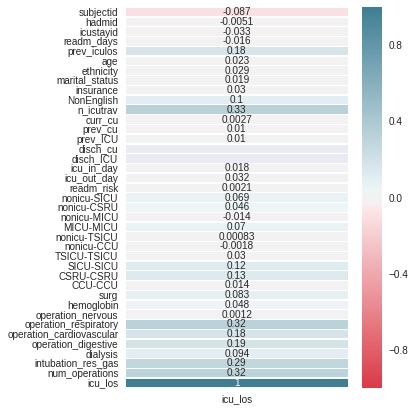

In [45]:
plt.figure(figsize=(5,7))
data_pcorr = df_icustay_f.corr()
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(data_pcorr[['icu_los']], annot=True, cmap = cmap, 
            linewidths=0.3)
plt.show()

# Predictive Modeling - Deep Learning
## Keras Sequential Model
The **Sequential** model is a linear stack of layers.

In [47]:
import sys, os
src_abspath = os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], 'src'))
sys.path.append(src_abspath)
from db import *
from clf import *

In [48]:
am_debugging = True
if am_debugging:
    # Fix random seed for reproducibility
    seed = 2
    np.random.seed(seed)
else:
    np.random.seed()

#### Partition: Training & Testing Sets

In [49]:
def data_partition(data, train_thres=0.75):
    """
    Helper function identifying indices for each record to be a part of the
    training set. The quantity of a given subject's set of records is determined
    by the training threshold.
    
    :param data: pandas DataFrame
    :param train_thres: float indicating threshold
    :return: list of training indices
    """
    if train_thres > 0.83:
        return "This helper function is not appropriate for training threshold > 83%."
    
    idx_lst = []
    subj_count = dict(Counter(data.subjectid))
    sid_lst = list(data.subjectid.value_counts().index.sort_values(ascending=True))
    for sid in sid_lst:
        idx_min = data['subjectid'][data.subjectid == sid].idxmin()
        if subj_count[sid] > 2:
            end_idx = idx_min + int(np.round(subj_count[sid] * train_thres))
            idx_lst += range(idx_min, end_idx)
        else:
            idx_lst += [idx_min]
    return idx_lst

In [50]:
data = df_icustay_f.copy().iloc[:3500,:]

train_idx = data_partition(data, 0.75)
train_data = data.ix[train_idx]
test_idx = data.index[data.index.isin(train_idx)==False]
test_data = data.ix[test_idx]

train_data.shape, test_data.shape

((2873, 39), (627, 39))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [51]:
train_data.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

In [52]:
X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]
y_train = np.array(train_data.iloc[:, -1])
y_test = np.array(test_data.iloc[:, -1])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2873, 35), (627, 35), (2873,), (627,))

#### Normalization

In [53]:
scaler = StandardScaler().fit(X_train) # scaler object fitted to training set

# Transform
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

# scaled_X_train, scaled_X_test = scale(X_train, X_test)
scaled_X_train.shape, scaled_X_test.shape, y_train.shape, y_test.shape

((2873, 35), (627, 35), (2873,), (627,))

#### Feature Selection

In [54]:
pass

### Model

In [57]:
model = Sequential()
model.add(Dense(35, input_dim=35, activation='relu'))
model.add(Dense(1))
# Compile model
model.compile(loss='mae', optimizer='rmsprop')

Train/Fit Model

In [58]:
model.fit(scaled_X_train, y_train)

Epoch 1/10
2873/2873 [==============================] - 0s - loss: 4.7233      
Epoch 2/10
2873/2873 [==============================] - 0s - loss: 3.8170     

### Metrics

In [156]:
model_pred = model.predict(scaled_X_test)
model_pred = model_pred.flatten() # np.reshape(a1, (-1,)).shape

#### Evaluate Model
`loss = mae`

Compare mae scores.

In [126]:
model.evaluate(scaled_X_test, y_test)

 32/627 [>.............................] - ETA: 4s

4.2863348450577048

In [220]:
np.mean(np.abs(model_pred - y_test))

4.2863349335257137

#### Compare Predictions

In [219]:
(model_pred.min(), model_pred.max())

(0.20458291, 21.525288)

In [158]:
model_pred[-10:]

array([ 6.95518112,  2.61530137,  2.22338223,  3.59324908,  9.0034008 ,
        4.78891993,  1.69598663,  2.63731956,  5.42521   ,  2.50321651], dtype=float32)

In [159]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

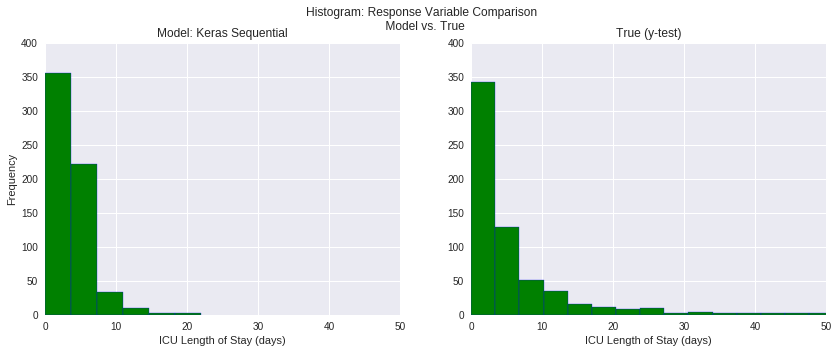

In [187]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(model_pred), bins=6, edgecolor='b', color='g')
plt.title("Model: Keras Sequential")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, edgecolor='b', color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [237]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, model_pred))

RMSE = 8.620 days


In [164]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The RMSE value of 8.6 days is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [235]:
print " MAE = %.3f" % mean_absolute_error(y_test, model_pred)

 MAE = 4.286


The average difference between prediction and observation is 4 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [246]:
print "r2 = %.3f" % r2_score(y_test, model_pred)

r2 = 0.163


The R<sup>2</sup> value is approximately 0.16, which indicates that the model does not fit the model well and is not very generalizable to future data.

### Error Visualization (MAE)

In [238]:
df_modelpred = pd.Series(model_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results = pd.concat([df_true, df_modelpred], axis=1)
residual = pd.Series(df_results['true'].sub(df_results['pred'], axis=0).abs(), name='resid')
df_results = pd.concat([df_results, residual], axis=1)
df_results

model_errort = df_results[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

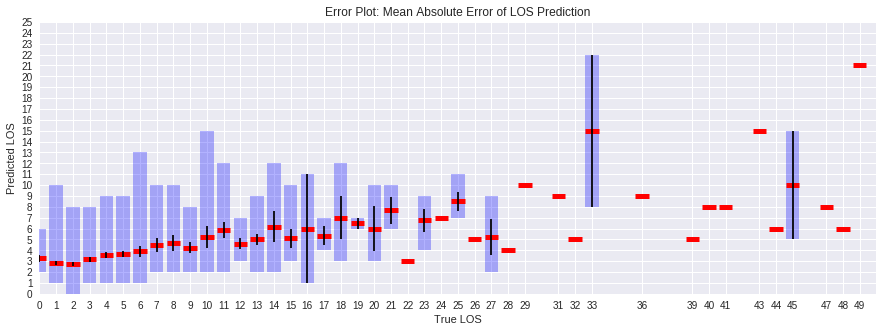

In [239]:
plt.subplots(1,1,figsize=(15,5))

# error bar
plt.bar(left=[i for i in model_errort.index.tolist()], 
        height=model_errort[['pred']].values[:,3] - model_errort[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=model_errort[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in model_errort.index.tolist()], 
        height=[0]*len(model_errort), 
        width=0.8, 
        bottom=model_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=model_errort[['pred']].values[:,2] / model_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(model_errort.index)
plt.yticks(model_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,25])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model - Regression (y < 12 days)

In [189]:
train_data_short = train_data[train_data['icu_los'] <=12]
test_data_short = test_data[test_data['icu_los'] <=12]

train_data_short.shape, test_data_short.shape

((2585, 36), (540, 36))

In [190]:
X_train2 = train_data_short.iloc[:, :-1]
X_test2 = test_data_short.iloc[:, :-1]
y_train2 = np.array(train_data_short.iloc[:, -1])
y_test2 = np.array(test_data_short.iloc[:, -1])

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((2585, 35), (540, 35), (2585,), (540,))

In [191]:
scaler2 = StandardScaler().fit(X_train2) # scaler object fitted to training set

# Transform
scaled_X_train2 = scaler.transform(X_train2)
scaled_X_test2 = scaler.transform(X_test2)

scaled_X_train2.shape, scaled_X_test2.shape, y_train2.shape, y_test2.shape

((2585, 35), (540, 35), (2585,), (540,))

Train/Fit Model

In [192]:
model.fit(scaled_X_train2, y_train2)

Epoch 1/10
2585/2585 [==============================] - 0s - loss: 1.8359     
Epoch 2/10
2585/2585 [==============================] - 0s - loss: 1.7740     

### Metrics

In [193]:
model_pred2 = model.predict(scaled_X_test2).flatten()

#### Compare Predictions

In [216]:
(model_pred2.min(), model_pred2.max())

(0.55316448, 9.9461918)

In [196]:
model_pred2[-10:]

array([ 3.58877444,  5.12914991,  2.74849582,  2.33156276,  3.28153801,
        2.66660833,  2.15788293,  2.73529816,  3.91729498,  2.33701873], dtype=float32)

In [197]:
y_test2[-10:]

array([ 4.398 ,  3.3319,  2.3326,  8.2449,  1.4131,  1.1249,  0.7122,
        5.344 ,  4.8595,  0.8851])

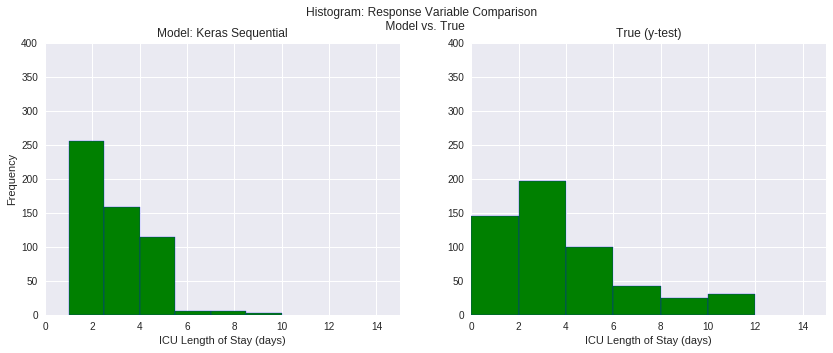

In [248]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(model_pred2), bins=6, edgecolor='b', color='g')
plt.title("Model: Keras Sequential")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,15])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test2), bins=6, edgecolor='b', color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,15])
plt.ylim([0,400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [240]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test2, model_pred2))

RMSE = 2.624 days


In [208]:
print "[%.2f,%.2f]" % (y_test2.min(), y_test2.max())

[0.00,11.89]


The model has an RMSE value of 2.6 days which is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [242]:
print "MAE = %.3f days" % mean_absolute_error(y_test2, model_pred2)

MAE = 1.882 days


The average difference between prediction and observation is 1.9 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [243]:
print "r2 = %.3f" % r2_score(y_test2, model_pred2)

r2 = 0.053


The R<sup>2</sup> value is approximately 0.05, which indicates that the model is not generalizable to new data.

### Error Visualization (MAE)

In [244]:
df_modelpred2 = pd.Series(model_pred2, name="pred").round()
df_true2 = pd.Series(y_test2, name = "true").round()

df_results2 = pd.concat([df_true2, df_modelpred2], axis=1)
residual2 = pd.Series(df_results2['true'].sub(df_results2['pred'], axis=0).abs(), name='resid')
df_results2 = pd.concat([df_results2, residual2], axis=1)

model_errort2 = df_results2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

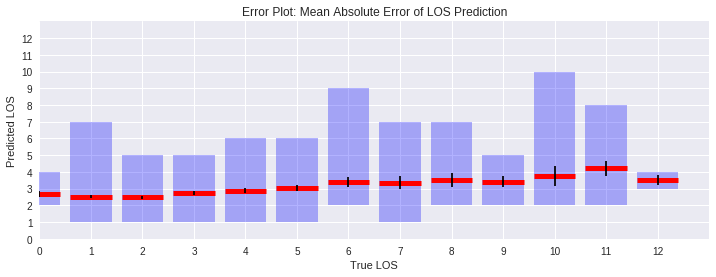

In [245]:
plt.subplots(1,1,figsize=(12,4))

# error bar
plt.bar(left=[i for i in model_errort2.index.tolist()], 
        height=model_errort2[['pred']].values[:,3] - model_errort2[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=model_errort2[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in model_errort2.index.tolist()], 
        height=[0]*len(model_errort2), 
        width=0.8, 
        bottom=model_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=model_errort2[['pred']].values[:,2] / model_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(model_errort2.index)
plt.yticks(model_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,13])
plt.ylim([0,13])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

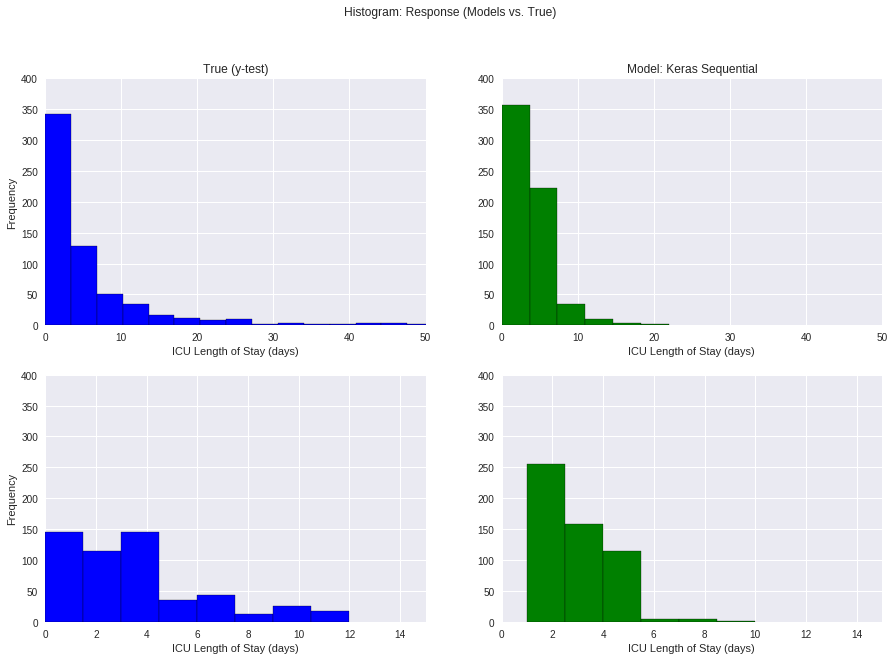

In [255]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.hist(np.round(y_test), bins=20, edgecolor='black', color='blue')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.hist(np.round(model_pred), bins=6, edgecolor='black', color='g')
plt.title("Model: Keras Sequential")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.hist(np.round(y_test2), bins=8, edgecolor='black', color='blue')
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,15])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(2,2,4)
plt.hist(np.round(model_pred2), bins=6, edgecolor='black', color='g')
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,15])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True)')

plt.show()

## Conclusion
### Main Points
  1. Deep Learning (Keras Sequential Neural Network) model is not significantly better than previously explored regression models.
    * The model suffers from the same issues such as the inability to predict the end-range.
  2. Assigning a more specific/shorter window did not yield much improvements in regression metrics, when comparing them relative to their range.
  
Model | RMSE | MAE | R<sup>2</sup> | Pred Range
:-----|:----:|:---:| :------------:| :---: |
Full LOS |8.6|4.3|0.16 | [0.21, 21.53]
Cut-off (12 days)|2.6|1.9|0.05 | [0.55, 10.0]

Deep Learning Model (Keras sequential - Neural Network) did not prove to be any better than previous regression models. Focusing on a shorter range of LOS did not yield much improvement as the decrease in the average prediction error (RMSE & MAE) are not significant relative to the range.

#### RMSE
In regards to RMSE, the models have relatively decent performances in the prediction of ICU length of stay for new, unseen data. The RMSE values are greater than the MAE values for all models, suggesting that there are a higher frequency of larger residuals as the metric penalizes bigger discrepancies.

#### MAE
All models are decent in terms of their mean absolute errors with values with an average error in prediction of 4-5 days for a complete dataset (LOS range [0, 68]) and 2 days for the shortened dataset (LOS range [0, 12]).

#### R<sup>2</sup> - Coefficient of Determination
The very low R<sup>2</sup> values indicate that the models have very poor predictive power. The model does not fit the data too well and may not be very generalizable to future data.